# Predict Target Next Close Using ${seq_length} days Back Candles of NYSE:SPY using LSTM
The result from LSTM is quite bad.
Todo: try timeseries model [moirai](https://huggingface.co/Salesforce/moirai-1.0-R-large) next time
## How to use?
Before running, please run `pip install -r requirements.txt` to install packages:
- PyTorch
- ta
- yfinance
- etc
## Import packages & Parameter settings

In [1]:
import numpy as np
import ta
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
seq_length = 30 # days to look back 
# Model parameters
input_size = 8  # Number of features
hidden_size = 128  # Number of LSTM units
num_layers = 10  # LSTM layers
output_size = 1  # Regression task (single output)
start_date = '2020-03-11'
end_date = '2025-02-01'
# Training parameters
num_epochs = 500
data = yf.download(tickers = 'SPY', start = start_date, end = end_date)
data.head(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2020-03-11,254.365875,261.393495,251.139500,260.243870,255316300
2020-03-12,230.028839,247.227000,229.630168,237.343850,392220700
2020-03-13,249.693130,251.695722,230.408942,243.917136,329566100
2020-03-16,222.370773,238.178232,220.062229,223.603836,297240000
2020-03-17,234.377060,237.501479,219.793397,227.182565,262070500
2020-03-18,222.509888,230.269916,211.402940,219.033171,327597100
2020-03-19,222.982697,229.352051,215.296841,221.814525,289322000
2020-03-20,213.373428,227.986895,213.093653,226.177695,347158800


In [2]:
data.columns = data.columns.droplevel(1) # drop the multi-level columns

In [3]:
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [4]:
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-03-11,254.365875,261.393495,251.139500,260.243870,255316300
2020-03-12,230.028839,247.227000,229.630168,237.343850,392220700
2020-03-13,249.693130,251.695722,230.408942,243.917136,329566100
2020-03-16,222.370773,238.178232,220.062229,223.603836,297240000
2020-03-17,234.377060,237.501479,219.793397,227.182565,262070500
...,...,...,...,...,...
2025-01-27,599.369995,599.690002,594.640015,594.809998,70361100
2025-01-28,604.520020,605.369995,597.250000,600.619995,44433300
2025-01-29,601.809998,604.130005,599.219971,603.719971,37177400


## Feature engineering

In [5]:
date_col = data.index

In [6]:
date_col

DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24',
               ...
               '2025-01-17', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31'],
              dtype='datetime64[ns]', name='Date', length=1231, freq=None)

In [7]:
# Adding indicators
data['RSI']=ta.momentum.rsi(data['Close'], window=15)
data['EMAF']=ta.trend.ema_indicator(data['Close'], window=20)
data['EMAM']=ta.trend.ema_indicator(data.Close, window=100)
data['EMAS']=ta.trend.ema_indicator(data.Close, window=150)

data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Date'], axis=1, inplace=True)

/var/folders/h4/j7vdjtxs623fxbdpr31d599r0000gn/T/ipykernel_91316/1704001543.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


## Take a look at our data

In [8]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
print(data_set.shape)
#print(data.shape)
#print(type(data_set))

(1081, 11)


## Data processing

In [9]:
def create_sequences(data, feature_num, seq_length):
    data_set = data.iloc[:, list(range(feature_num)) + [-1]].values
    sc = MinMaxScaler(feature_range=(0,1))
    data_set_scaled = sc.fit_transform(data_set)
    X = data_set_scaled[:, :feature_num]
    y = data_set_scaled[:, -1]
    X_tensor = torch.tensor(np.array([data_set_scaled[i-seq_length:i,:feature_num].copy() for i in range(seq_length,len(data_set_scaled))]), dtype=torch.float32)
    y_tensor = torch.tensor([y[i + seq_length] for i in range(len(y) - seq_length)], dtype=torch.float32).view(-1, 1)
    # X_tensor = X_tensor.view(data.shape[0], seq_length, feature_num)  # Sequence length = 1 (since we have independent rows)
    # Create dataset and split into train/test
    # Set the split ratios
    train_ratio = 0.7
    val_ratio = 0.15

    # Calculate the split indices
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    test_size = len(data) - train_size - val_size

    # Split the data based on time awareness (no randomization)
    train_data, val_data, test_data = X_tensor[:train_size], X_tensor[train_size:train_size+val_size], X_tensor[train_size+val_size:]
    train_targets, val_targets, test_targets = y_tensor[:train_size], y_tensor[train_size:train_size+val_size], y_tensor[train_size+val_size:]
    print('Train:',train_data.shape)
    print('Val:',val_data.shape)
    print('Test:',test_targets.shape)

    # Create datasets for PyTorch DataLoader
    train_dataset = TensorDataset(train_data, train_targets)
    val_dataset = TensorDataset(val_data, val_targets)
    test_dataset = TensorDataset(test_data, test_targets)

    # Create DataLoaders for batching
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # No shuffling for time series
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    return train_loader, val_loader, test_loader, sc

train_loader, val_loader, test_loader, scaler = create_sequences(data, feature_num=input_size, seq_length=seq_length)

Train: torch.Size([756, 30, 8])
Val: torch.Size([162, 30, 8])
Test: torch.Size([133, 1])


In [10]:
train_size = train_loader.dataset.tensors[0].shape[0]
val_size = val_loader.dataset.tensors[0].shape[0]
test_size = test_loader.dataset.tensors[0].shape[0]

In [11]:
train_size + val_size + test_size

1051

In [12]:
date_show = date_col[-test_size:]
len(date_show)

133

In [13]:
X_min = data.iloc[:, 0:input_size].values.min()  # minimum value of original data
X_max = data.iloc[:, 0:input_size].values.max()  # maximum value of original data
y_min = data.iloc[:, -1].values.min()
y_max = data.iloc[:, -1].values.max()
print(f'X is from {X_min:.2f} to {X_max:.2f}')
print(f'y is from {y_min:.2f} to {y_max:.2f}')

X is from 25.91 to 610.78
y is from 307.09 to 609.75


## Create LSTM Model

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Take the last timestep output
        return out

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


## Set criterion and optimizer

In [15]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [16]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [10/500], Loss: 0.0097
Epoch [20/500], Loss: 0.0097
Epoch [30/500], Loss: 0.0072
Epoch [40/500], Loss: 0.0028
Epoch [50/500], Loss: 0.0011
Epoch [60/500], Loss: 0.0011
Epoch [70/500], Loss: 0.0007
Epoch [80/500], Loss: 0.0006
Epoch [90/500], Loss: 0.0005
Epoch [100/500], Loss: 0.0006
Epoch [110/500], Loss: 0.0008
Epoch [120/500], Loss: 0.0006
Epoch [130/500], Loss: 0.0005
Epoch [140/500], Loss: 0.0008
Epoch [150/500], Loss: 0.0005
Epoch [160/500], Loss: 0.0007
Epoch [170/500], Loss: 0.0007
Epoch [180/500], Loss: 0.0006
Epoch [190/500], Loss: 0.0006
Epoch [200/500], Loss: 0.0008
Epoch [210/500], Loss: 0.0007
Epoch [220/500], Loss: 0.0010
Epoch [230/500], Loss: 0.0008
Epoch [240/500], Loss: 0.0003
Epoch [250/500], Loss: 0.0005
Epoch [260/500], Loss: 0.0005
Epoch [270/500], Loss: 0.0004
Epoch [280/500], Loss: 0.0007
Epoch [290/500], Loss: 0.0003
Epoch [300/500], Loss: 0.0005
Epoch [310/500], Loss: 0.0011
Epoch [320/500], Loss: 0.0004
Epoch [330/500], Loss: 0.0003
Epoch [340/500], Lo

## Testing

In [20]:
model.eval()
test_loss = 0
# List to store predictions
y_pred_list = []
y_test_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_test_list.append(y_batch)
        # Collect predictions
        y_pred_list.append(y_pred)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

print(f"Test Loss(MSE): {test_loss/len(test_loader):.4f}")
# Concatenate predictions into a single tensor
y_pred_tensor = torch.cat(y_pred_list, dim=0)

# Optionally, convert to NumPy array if needed
y_pred = y_pred_tensor.numpy()  # y_pred shape will be (num_samples, 1)

# Example: Show the first 5 predictions
# print("Predictions: ", y_pred[:5])

Test Loss(MSE): 0.2174


In [21]:
test_loader.dataset.tensors[1].shape

torch.Size([133, 1])

## Visualize the predicted result

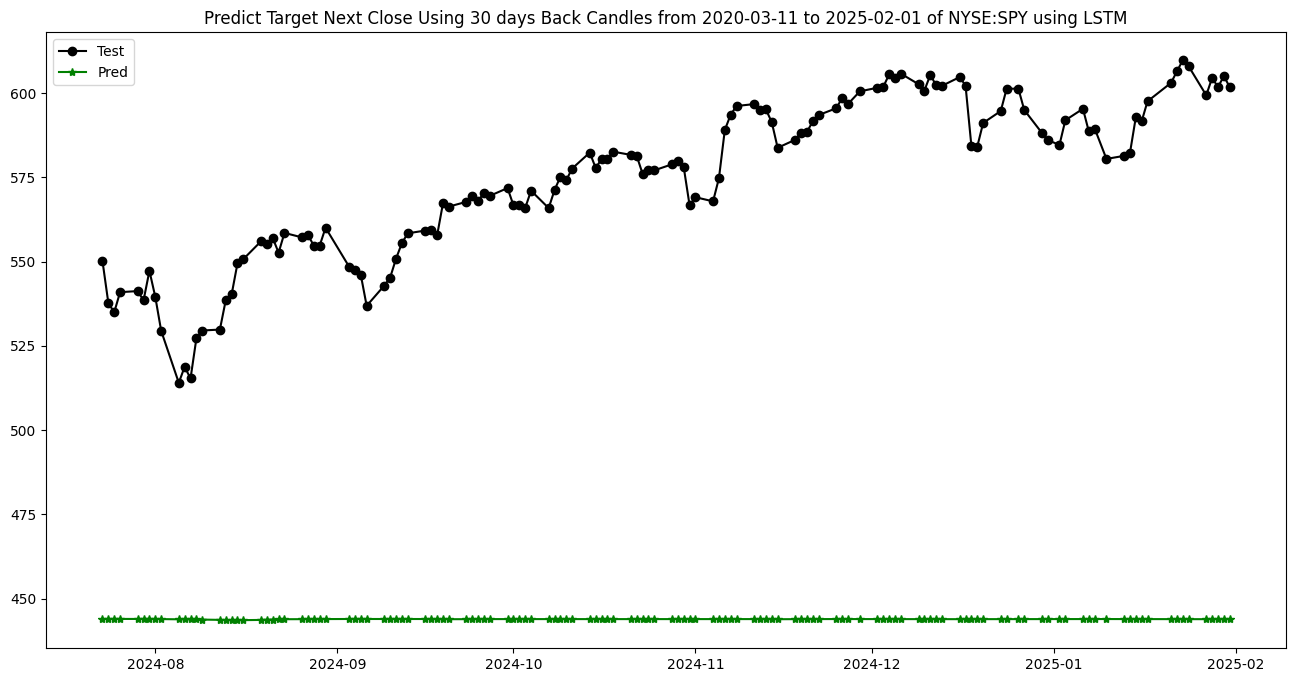

In [22]:
visualize_days = test_size
plt.figure(figsize=(16,8))
y_test_original = [y * (y_max - y_min) + y_min for y in y_test_list] # Reversing normalization
y_pred_original = [y * (y_max - y_min) + y_min for y in y_pred_list] # Reversing normalization
y_test = np.concatenate([item.numpy().flatten() for item in y_test_original])  # Flatten and concatenate
y_pred = np.concatenate([item.numpy().flatten() for item in y_pred_original])  # Flatten and concatenate
plt.title(f'Predict Target Next Close Using {seq_length} days Back Candles from {start_date} to {end_date} of NYSE:SPY using LSTM')
plt.plot(date_show[-visualize_days:], y_test[-visualize_days:], color = 'black', label = 'Test', marker='o')
plt.plot(date_show[-visualize_days:], y_pred[-visualize_days:], color = 'green', label = 'Pred', marker='*')
plt.legend(loc='upper left')
plt.legend()
plt.show()